# Aplicar DecisionTreeRegressor y DecisionTreeClassifier sobre los datos limpios.

**Autor:** Jean Pool Marín Betancur  
**Fecha:** 2025-06-05
**Versión:** 1.0  

---
# 1. Configuración del Entorno e Importaciones:
---

In [286]:
# Se importan las librerias necesarias.
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


# Se importan las librerias personalizadas.
sys.path.append(os.path.abspath('..'))
import src.train_sklearn_models as tsm

In [287]:
# Configuración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

In [288]:
# Se define la ruta y se cargan los datos limpios.
data_path = os.path.join('..','..', '01_data_preparation', 'data', 'processed', 'US_Renewable_Energy_Consumption_Imputed.csv')
df_processed = pd.read_csv(data_path , index_col='Datetime', parse_dates=True)

## 2. Regresión con *DesicionTreeRegressor*

### 2.1 Definición del problema de regresión.

Para comenzar se debe tener claro el problema en cuestión que se desea solucionar por medio del algoritmo de *Arbol de Desición*, para esto se debe definir principalmente la variable objetivo o *target* del problema y sus variables independientes o *features*, para el correcto entrenmiento del modelo. 

Para este caso analizando la dataset de *Consumo de Energías Renovables en EEUU (1973 -2024)*,  se identificó una fuente de energía en cuestión como posible candidata debido a su crecimiento emergente e importancia en la última decada, esta fuente de energía corresponde a `Solar Energy`, por lo que se definirá como la variable objetivo o *target* del problema, mientras que las variables independientes o *features* corresponderán a cada uno de los años y meses del dataset, de tal forma que se pueda entrenar un modelo que prediga el consumo de energía solar en función de los años y meses.

In [289]:
# Definir Variable Objetivo y Características Iniciales
target_reg = 'Solar Energy' # Variable objetivo para regresión

# --- Crear Características (Features) ---
df_features_reg = df_processed.iloc[2160:].copy()

# Características Temporales Básicas (del índice datetime)
df_features_reg['year'] = df_features_reg.index.year
df_features_reg['month'] = df_features_reg.index.month

# Columnas a excluir
features_to_exclude = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant','Biomass Losses and Co-products',
    'Biomass Energy','Renewable Diesel Fuel','Total Renewable Energy',
    'Other Biofuels','Conventional Hydroelectric Power', 'Biodiesel', 'Sector'
]


In [290]:
# Se definen las caracteristicas potenciales para el modelo de regresión.
final_features_reg = [col for col in df_features_reg.columns if col not in features_to_exclude]

# Se definen las variables de entrenamiento y prueba.
X_reg = df_features_reg[final_features_reg]
y_reg = df_features_reg[target_reg]

print(f"\nForma de X_reg (características): {X_reg.shape}")
print(f"Forma de y_reg (objetivo): {y_reg.shape}")
print("\nPrimeras filas de X_reg:")
print(X_reg.head())
print("\nPrimeras filas de y_reg:")
print(y_reg.head())
print("\nCaracterísticas finales para regresión:")
print(final_features_reg)


Forma de X_reg (características): (900, 2)
Forma de y_reg (objetivo): (900,)

Primeras filas de X_reg:
            year  month
Datetime               
2009-01-01  2009      1
2009-01-01  2009      1
2009-01-01  2009      1
2009-01-01  2009      1
2009-01-01  2009      1

Primeras filas de y_reg:
Datetime
2009-01-01   0.14
2009-01-01   0.03
2009-01-01   0.03
2009-01-01   3.06
2009-01-01   1.60
Name: Solar Energy, dtype: float64

Características finales para regresión:
['year', 'month']


### 2.2 División de Datos (Cronológica)

Una vez identifica el modelo y su forma, se procede a dividir los datos potenciales en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. El conjunto de entrarnamiento se utiliza para entrenar el modelo, mientras que el conjunto de prueba se utiliza para evaluar su rendimiento. La proporción de datos entre el conjunto de entrenamiento y el conjunto de prueba es importante, ya que un conjunto de entrenamiento demasiado grande puede llevar a un modelo que se adapte demasiado a los datos de entrenamiento y no genere buenos resultados en el conjunto de prueba, para este caso se escoje el 80% para el conjunto de entrenamiento y el 20% para el conjunto de prueba.

In [291]:
# División de datos cronológica
train_ratio = 0.8 # Usar el 80% de los datos para entrenar, el 20% para probar

# El split debe ser en el mismo punto para X e y
split_point_reg = int(len(X_reg) * train_ratio)

X_train_reg, X_test_reg = X_reg.iloc[:split_point_reg], X_reg.iloc[split_point_reg:]
y_train_reg, y_test_reg = y_reg.iloc[:split_point_reg], y_reg.iloc[split_point_reg:]

print("División de datos para Regresión:")
print(f"Forma de X_train_reg: {X_train_reg.shape}, Forma de y_train_reg: {y_train_reg.shape}")
print(f"Forma de X_test_reg: {X_test_reg.shape}, Forma de y_test_reg: {y_test_reg.shape}")
print(f"Fechas de entrenamiento: {X_train_reg.index.min()} a {X_train_reg.index.max()}")
print(f"Fechas de prueba: {X_test_reg.index.min()} a {X_test_reg.index.max()}")

División de datos para Regresión:
Forma de X_train_reg: (720, 2), Forma de y_train_reg: (720,)
Forma de X_test_reg: (180, 2), Forma de y_test_reg: (180,)
Fechas de entrenamiento: 2009-01-01 00:00:00 a 2020-12-01 00:00:00
Fechas de prueba: 2021-01-01 00:00:00 a 2023-12-01 00:00:00


### 2.3  Entrenamiento del DecisionTreeRegressor

----- Texto aquí!

In [292]:
# Entrenamiento del Modelo
dtr = DecisionTreeRegressor(
    random_state=42, # Para reproducibilidad
    max_depth=6,      # Controla la complejidad del árbol, previene overfitting
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3   # Mínimo de muestras en una hoja
)

# Ajustar el modelo
dtr.fit(X_train_reg, y_train_reg)

print("Modelo DecisionTreeRegressor entrenado.")
print("Parámetros del modelo:", dtr.get_params())


Modelo DecisionTreeRegressor entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


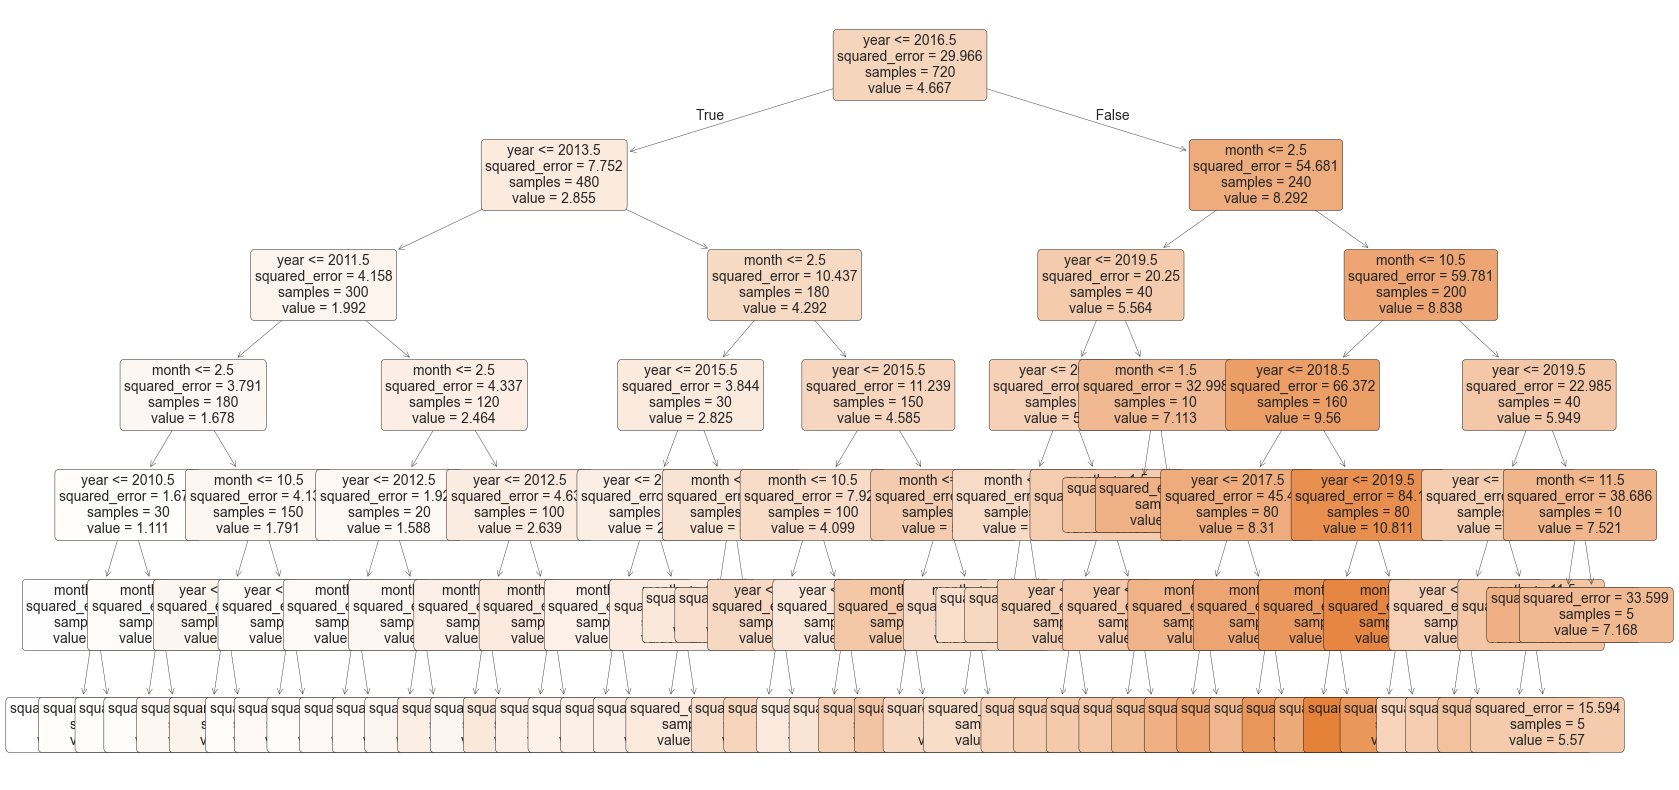

In [293]:
# Se gráfica el arbol de decisión del modelo entrenado.
plt.figure(figsize=(20, 10))

# Plotear el árbol de decisión
plot_tree(
    dtr, 
    feature_names=X_train_reg.columns,  # Nombres de las características
    filled=True,                        # Colorea los nodos según la pureza
    rounded=True,                       # Bordes redondeados en los nodos
    fontsize=10                         # Tamaño de la fuente
)

# Mostrar el gráfico
plt.show()

### 2.4 Predicciones y Evaluación (Regresión)

----- texto aqui! Objetivo: Usar el modelo entrenado para hacer predicciones sobre el conjunto de prueba y evaluar qué tan buenas son esas predicciones.


--- Resultados de Evaluación para DecisionTreeRegressor (Solar Energy) ---
RMSE (Error Cuadrático Medio Raíz): 231.7049
MAE (Error Absoluto Medio): 10.3680
R² (Coeficiente de Determinación): -0.0570


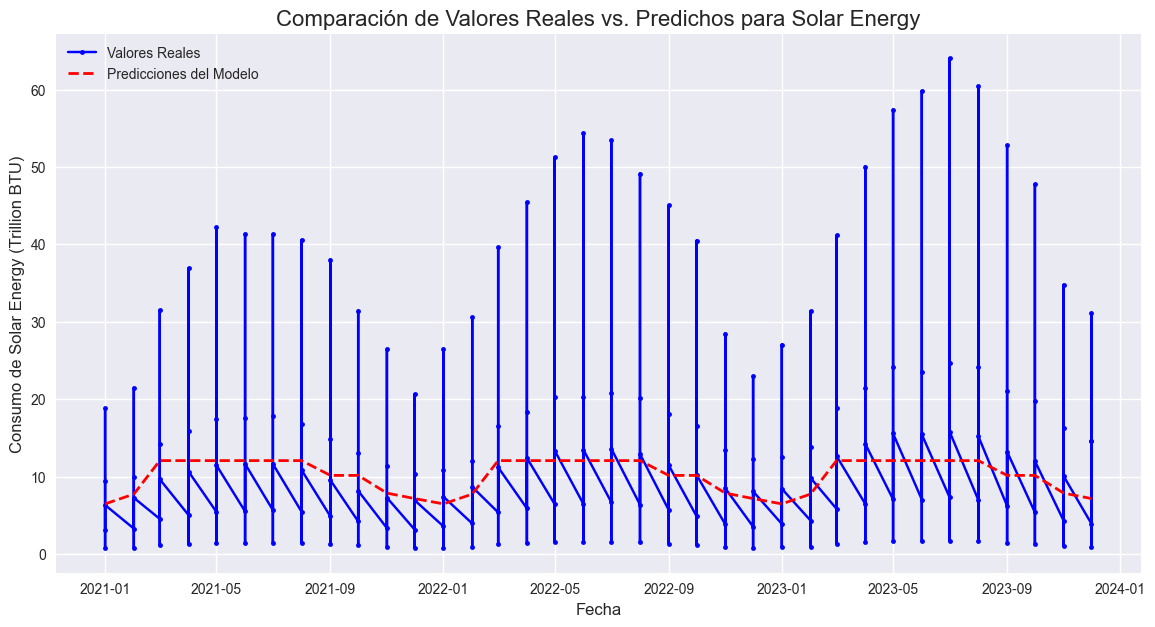

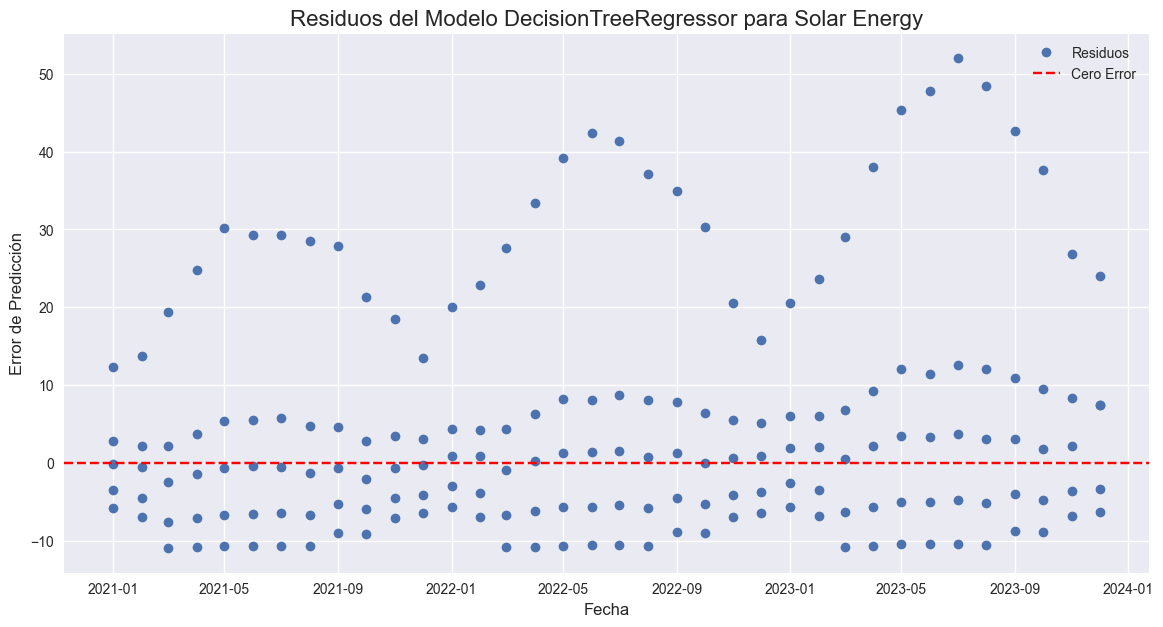

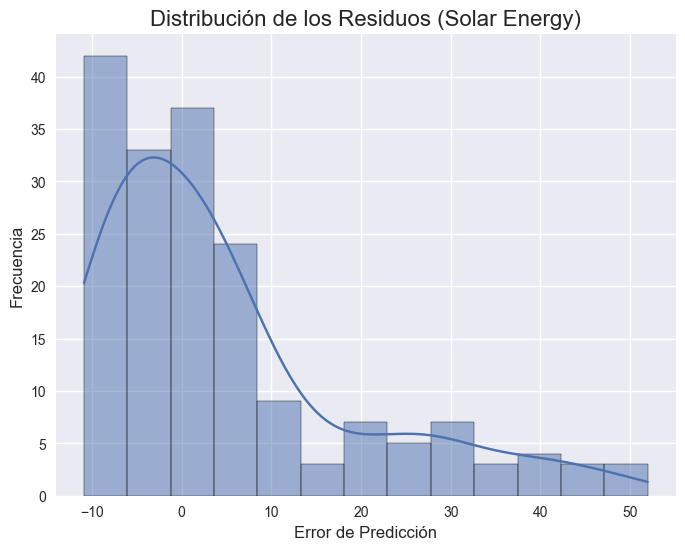

In [294]:
# Realizar predicciones en el conjunto de prueba
y_pred_reg = dtr.predict(X_test_reg)

# Calcular métricas de evaluación
rmse_reg = mean_squared_error(y_test_reg, y_pred_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"\n--- Resultados de Evaluación para DecisionTreeRegressor ({target_reg}) ---")
print(f"RMSE (Error Cuadrático Medio Raíz): {rmse_reg:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_reg:.4f}")
print(f"R² (Coeficiente de Determinación): {r2_reg:.4f}")

# --- Visualización de Predicciones vs. Reales ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_reg.index, y_test_reg, label='Valores Reales', marker='.', linestyle='-', color='blue')
plt.plot(y_test_reg.index, y_pred_reg, label='Predicciones del Modelo', marker='x', linestyle='--', color='red', linewidth=2)
plt.title(f'Comparación de Valores Reales vs. Predichos para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo de {target_reg} (Trillion BTU)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Residuos ---
# Los residuos son la diferencia entre los valores reales y los predichos
residuos_reg = y_test_reg - y_pred_reg
plt.figure(figsize=(14, 7))
plt.plot(residuos_reg.index, residuos_reg, label='Residuos', marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--', label='Cero Error')
plt.title(f'Residuos del Modelo DecisionTreeRegressor para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error de Predicción', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(residuos_reg, kde=True)
plt.title(f'Distribución de los Residuos ({target_reg})', fontsize=16)
plt.xlabel('Error de Predicción', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

El análisis del modelo DecisionTreeRegressor revela un rendimiento limitado en la predicción del consumo de energía solar. Si bien el modelo captura tendencias iniciales entre 2014 y 2020, subestima significativamente los picos de consumo a partir de 2020, con errores de hasta 60 trillones de BTU. Esto se refleja en un R² de -0.3701, un RMSE de 145.919 y un MAE de 7.219, indicando que, aunque muchos errores son pequeños, los errores en los valores altos afectan gravemente el ajuste. Se recomienda explorar modelos más robustos, como Random Forest o Gradient Boosting, para mejorar la precisión en la predicción de picos de consumo.

### 2.5 Optimización de Hiperparámetros

---- Texto aquí! Objetivo: Encontrar la mejor combinación de hiperparámetros para el DecisionTreeRegressor para mejorar su rendimiento predictivo, usando validación cruzada apropiada para series temporales.

In [295]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de regresión.
param_grid_dtr = {
    'max_depth': [3, 5, 7, 10, None], # None significa sin límite
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['squared_error', 'absolute_error'] # Antes 'mse', 'mae'
}
# TimeSeriesSplit divide los datos en k folds consecutivos
tscv = TimeSeriesSplit(n_splits=5) # Usar menos splits si el dataset de entreno es pequeño

grid_search_dtr = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dtr,
    cv=tscv,
    scoring='neg_mean_squared_error', # GridSearchCV maximiza, por eso negativo
    verbose=1, # Muestra progreso
    n_jobs=-1 # Usa todos los procesadores
) 

grid_search_dtr.fit(X_train_reg, y_train_reg)

print(f"\nMejores Hiperparámetros para DecisionTreeRegressor: {grid_search_dtr.best_params_}")
print(f"Mejor puntuación (neg_MSE) en CV: {grid_search_dtr.best_score_:.4f}")


Fitting 5 folds for each of 90 candidates, totalling 450 fits



Mejores Hiperparámetros para DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor puntuación (neg_MSE) en CV: -25.7451


In [296]:
# Entrenar el modelo final con los mejores parámetros
best_dtr = grid_search_dtr.best_estimator_

# Re-evaluar el mejor modelo en el conjunto de prueba
y_pred_best_dtr = best_dtr.predict(X_test_reg)
rmse_best_dtr = mean_squared_error(y_test_reg, y_pred_best_dtr)
mae_best_dtr = mean_absolute_error(y_test_reg, y_pred_best_dtr)
r2_best_dtr = r2_score(y_test_reg, y_pred_best_dtr)

print(f"\n--- Resultados del Mejor DTR en Test Set ---")
print(f"RMSE: {rmse_best_dtr:.4f}")
print(f"MAE: {mae_best_dtr:.4f}")
print(f"R²: {r2_best_dtr:.4f}")


--- Resultados del Mejor DTR en Test Set ---
RMSE: 230.2295
MAE: 10.3620
R²: -0.0503
